##Recognizing ASL Fingerspelling Using Machine Learning
####Dataset Name: ASL Alphabet
####[Kaggle Data Soruce](https://www.kaggle.com/datasets/grassknoted/asl-alphabet)
####Goal: Develop a machine learning model to recognize ASL fingerspelling from images.

####Dataset Overview:
- American Sign Language alphabet dataset from Kaggle
- Contains 87,000 training images across 29 classes
- 26 classes represent letters A-Z and 3 additional classes

###Dataset Characteristics:
- Images show hand gestures against backgrounds
- Images 200x200 pixels
- Each image shows static hand position corresponding to a letter

###Class Selection:
- Despite having 29 classes in the full dataset, my analysis focuses on 18 letters

###The Objective
- To accurately classify ASL alphabet images into their respective letter classes

In [708]:
import glob
import os
import pandas as pd
import matplotlib.pyplot as plt
import random
import numpy as np
import cv2
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import RMSprop

In [709]:
dataset_path = "./asl_alphabet_data"

In [710]:
#grabs all the folder names in the dataset and sorts them
all_classes = sorted([os.path.basename(folder) for folder in glob.glob(os.path.join(dataset_path, "*"))])

def print_classes(title, class_list, rows, cols):
    #prints the title along with the number of items in the class list
    print(f"{title}: {len(class_list)}")
    #prints a header for the dataset classes
    print("\nDataset Classes:")
    index = 0 #keep track of the current position
    for row in range(rows):
        row_classes = [] #stores the items for the current row
        for col in range(cols):
            row_classes.append(class_list[index]) #adds the class name to the row list
            index += 1 #moves to the next class in the list
        print(" | ".join(row_classes)) #prints the row

#calls print_class function
print_classes("Total Dataset Classes", all_classes, 3, 9)

Total Dataset Classes: 27

Dataset Classes:
A | B | C | D | E | F | G | H | I
J | K | L | M | N | O | P | Q | R
S | T | U | V | W | X | Y | Z | nothing


---
###Selected Letters 

I'm picking a smaller set of ASL letters to make the dataset easier to work with and keep things running smoothly on my computer. Some letters, like "J" and "Z," need movement to sign, so they don’t work as well with static images.

In [712]:
#list of ASL letters we selected for this project
asl_keep = ["A", "B", "C", "D", "E", "F", "H", "I", "L", "O", "Q", "R", "S", "U", "V", "W", "X", "Y"]

#calls print_class function
print_classes("Selected ASL Letters", asl_keep, 2, 9)

Selected ASL Letters: 18

Dataset Classes:
A | B | C | D | E | F | H | I | L
O | Q | R | S | U | V | W | X | Y


In [713]:
#list to store image file paths for selected asl letters
asl_paths_train = []

for letter in asl_keep:
    #creates the full path to the letters folder
    letter_path = os.path.join(dataset_path, letter)
    #grabs all jpg images inside the letters folders
    letter_images = glob.glob(os.path.join(letter_path, "*.jpg"))
    #adds up to 500 images from this letter to the training list
    asl_paths_train.extend(letter_images[:500])

#extracts the letter label from each image
asl_labels_train = [os.path.basename(os.path.dirname(img)) for img in asl_paths_train]

#creates a df with the image paths and their labels
train_asl_df = pd.DataFrame({"image_path": asl_paths_train, "letter_label": asl_labels_train})

#prints total number of images added to the dataset
print(f"\nTotal images loaded: {len(train_asl_df)}")
#counts how many images belong to each letter
class_distribution = train_asl_df['letter_label'].value_counts()
#sort alphabetically instead of by count
class_distribution = class_distribution.sort_index()

#prints a breakdwon of how many images there are per class
print("\nImages per class:")
print("-" * 20)
for letter, count in class_distribution.items():
    print(f"Letter {letter}: {count:4d} images")
print("-" * 20)


Total images loaded: 9000

Images per class:
--------------------
Letter A:  500 images
Letter B:  500 images
Letter C:  500 images
Letter D:  500 images
Letter E:  500 images
Letter F:  500 images
Letter H:  500 images
Letter I:  500 images
Letter L:  500 images
Letter O:  500 images
Letter Q:  500 images
Letter R:  500 images
Letter S:  500 images
Letter U:  500 images
Letter V:  500 images
Letter W:  500 images
Letter X:  500 images
Letter Y:  500 images
--------------------


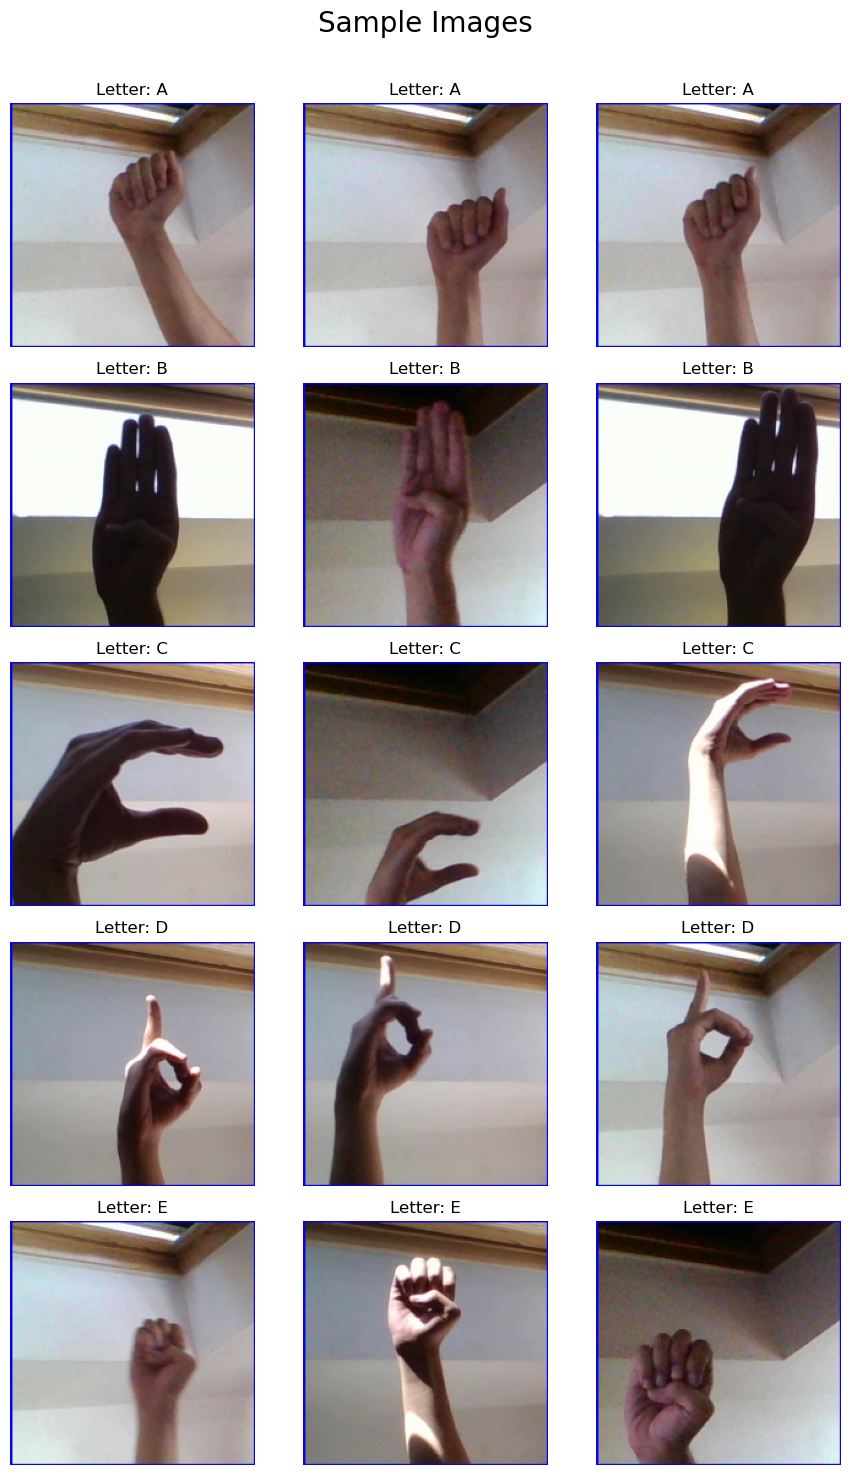

In [714]:
#display a grid of sample images for letters
letters = asl_keep[:5]
samples_per_letter = 3

#creates a grid of subplots on the number of letter and samples per letter
rows = len(letters)
cols = samples_per_letter
fig, axes = plt.subplots(rows, cols, figsize=(cols*3, rows*3))


for i, letter in enumerate(letters):
    #randomly selects the specified number of images for this letter
    letter_samples = train_asl_df[train_asl_df['letter_label'] == letter].sample(samples_per_letter)
    
    for j, (_, row) in enumerate(letter_samples.iterrows()):
        #load the image from its file path
        img = plt.imread(row['image_path'])
        #displays the image in the corresponding subplit
        axes[i, j].imshow(img)
        #sets the title above each image with the letter label
        axes[i, j].set_title(f"Letter: {letter}")
        #removes axis markings
        axes[i, j].axis('off')
        
        for spine in axes[i, j].spines.values():
            #adds a border around each image  
            spine.set_visible(True)
            spine.set_color('gray')
            spine.set_linewidth(0.5)

#sets the overall title for the entire gird
plt.suptitle("Sample Images", fontsize=20)
#adjusts the layout to prevent overlapping
plt.tight_layout(rect=[0, 0, 1, 0.97])
#displays the plot
plt.show()

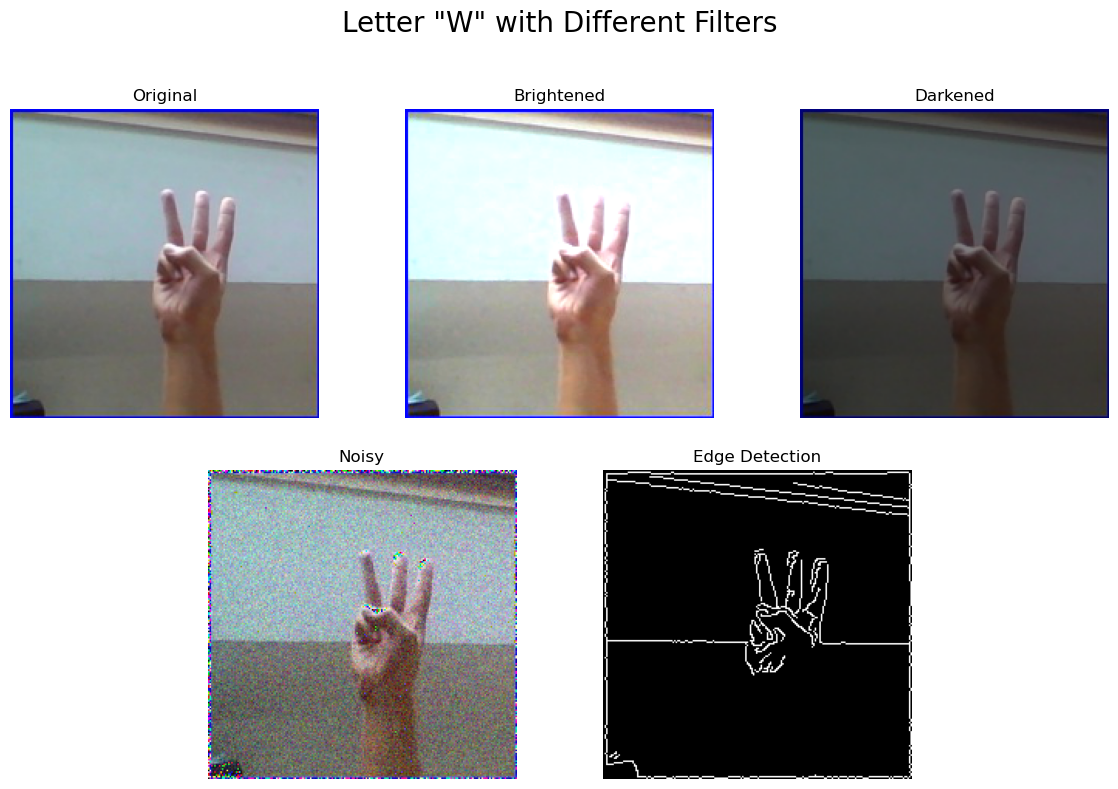

In [715]:
#randomly select letter from the dataset
letter = random.choice(asl_keep)

#grabs a random image from the selected letter
img_row = train_asl_df[train_asl_df['letter_label'] == letter].sample(1).iloc[0]
#gets the file path of the selected images
img_path = img_row['image_path']

#loads the image
img = plt.imread(img_path)

#sets up the figure and grid
fig = plt.figure(figsize=(12, 8))
#main title
fig.suptitle(f"Letter \"{letter}\" with Different Filters", fontsize=20)

#creates a 2 row 3 column grid
grid = plt.GridSpec(2, 3, figure=fig, height_ratios=[1, 1])

#subplots for the first row
ax1 = fig.add_subplot(grid[0, 0])
ax2 = fig.add_subplot(grid[0, 1])
ax3 = fig.add_subplot(grid[0, 2])

#subplots for the second row
ax4 = fig.add_subplot(grid[1, 0:2])  #spans columns 0 and 1
ax5 = fig.add_subplot(grid[1, 1:3])  #spans columns 1 and 2

#first row first column will show the original image
ax1.imshow(img)
ax1.set_title("Original")

#first row second column will show a brightened image
bright_img = np.clip(img * 1.5, 0, 255).astype(np.uint8) #increase the brightness by multipling the pixel values
ax2.imshow(bright_img)
ax2.set_title("Brightened")

#first row third column will show a darkened image
dark_img = np.clip(img * 0.5, 0, 255).astype(np.uint8) #decrease the brightness by multipling pixel values
ax3.imshow(dark_img)
ax3.set_title("Darkened")

#second row first column/second column will show a noisy image
noisy_img = img.copy()
noise = np.random.normal(0, 20, img.shape).astype(np.uint8) #generates random Gaussian noise 
noisy_img = np.clip(img + noise, 0, 255).astype(np.uint8) #adds noise and clips values to keep within range 
ax4.imshow(noisy_img)
ax4.set_title("Noisy")

#second row second column/third column will show edge detection
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) #converts to grayscale
edges = cv2.Canny(gray, 100, 200) #applies canny edge detection
ax5.imshow(edges, cmap='gray')
ax5.set_title("Edge Detection")

#hides the axes for all subplots
all_axes = [ax1, ax2, ax3, ax4, ax5]
for ax in all_axes:
    ax.axis('off')

#adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])
#display plots
plt.show()

-----
###K-Means Clustering
- Before going into supervised learning, we will apply K-means clustering to find patterns
- This will help us:
    - Discover groupings in letters
    - Find similar letters that might be difficult to distinguish in the future
    - Understand the structure of our dataset

In [717]:
#how many images to sample per letter
sample_size_per_class = 50 
#empty df to store the images
sampled_df = pd.DataFrame()

for letter in asl_keep:
    #filters the dataset to get only images of the current letter
    letter_df = train_asl_df[train_asl_df['letter_label'] == letter]
    #randomly selects the specificed number of images for this letter
    letter_sample = letter_df.sample(min(sample_size_per_class, len(letter_df)))
    #adds the sampled images to the main df
    sampled_df = pd.concat([sampled_df, letter_sample])

#resets the index after sampling
sampled_df = sampled_df.reset_index(drop=True)

#list to store image arrays
X_sample = []
for img_path in sampled_df['image_path']:
    #reads the image from the file path
    img = cv2.imread(img_path)
    #resizes the image to 64 x 64
    img_resized = cv2.resize(img, (64, 64))
    #adds the processed image the the list
    X_sample.append(img_resized)

#convers the list into a numpy array
X_sample = np.array(X_sample)
#extracts the letter labels
y_sample = sampled_df['letter_label'].values

#flattens the images into 1D arrays 
X = X_sample.reshape(len(X_sample), -1)
#normalizes pixel values to be between 0 and 1
X = X.astype(float) / 255.  

#prints the shape of the processed image array
print("Array Shape:", X.shape)
print(f"Number of Features per Image: {X.shape[1]}")

Array Shape: (900, 12288)
Number of Features per Image: 12288


In [718]:
#initialize k-means clustering with the number of ASL letters as clusters
#sets a number of inits
#fixes the state to reproduce
kmeans = KMeans(n_clusters=18, n_init=50, random_state=42)
#fits the k-means model to the image data
kmeans.fit(X)

#gets the cluster labels assigned to each image
kmeans_labs = kmeans.labels_
#computs the distance of each image to each cluster
X_distance = kmeans.transform(X)

#finds the index of the closest image to each cluster center
rep_letter_index = np.argmin(X_distance, axis=0)

#selects the representative images for each cluster
X_rep_letters = X_sample[rep_letter_index]
#gets the corresponding letter labels for those representative images  
y_rep_letters = y_sample[rep_letter_index]

#calculates and prints the silhouette score
print("Silhouette Score:", silhouette_score(X, kmeans_labs))

Silhouette Score: 0.16807283993101463


K-Means Centroid ASL Letter Images:



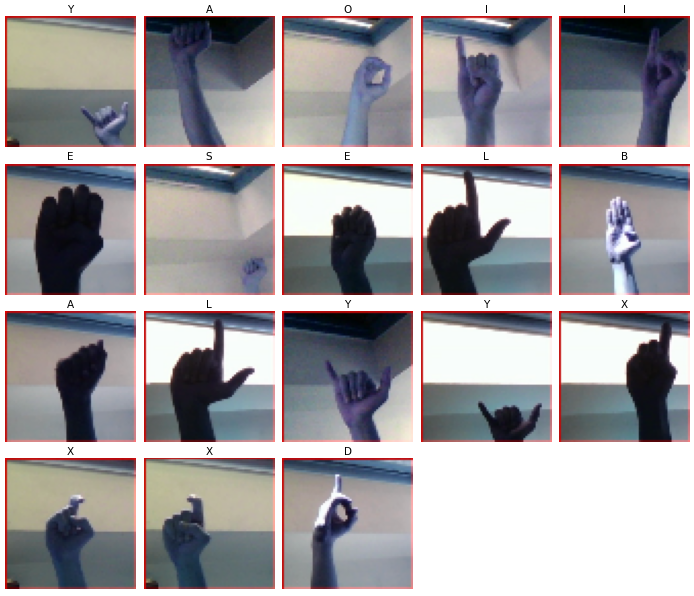

In [719]:
#number of groups
n_groups = 18
#calculates the number of rows needed
rows = int(np.ceil(n_groups / 5))
#no more than 5 columns, or fewer if there are fewer group
cols = min(5, 18)

#creates a grid of subplots
fig1, ax1 = plt.subplots(rows, cols, figsize=(14, rows * 3), dpi=50)
#flattens the axes array
ax1 = ax1.flatten()

for i in range(n_groups):
    #displays the image for this cluster 
    im = ax1[i].imshow(X_rep_letters[i])
    #gets the corresponding letter label
    lab = y_rep_letters[i]
    #sets the title of the image to its ASL letter 
    ax1[i].set_title(f"{lab}", fontsize=15)
    #hides axis markings
    ax1[i].axis('off')

for j in range(n_groups, len(ax1)):
    ax1[j].axis('off')
    #turns off any extra unused subplots 

#prints before showing the images
print("K-Means Centroid ASL Letter Images:\n")
#adjusts layout to prevent overlap
plt.tight_layout()
#displays plot
plt.show()

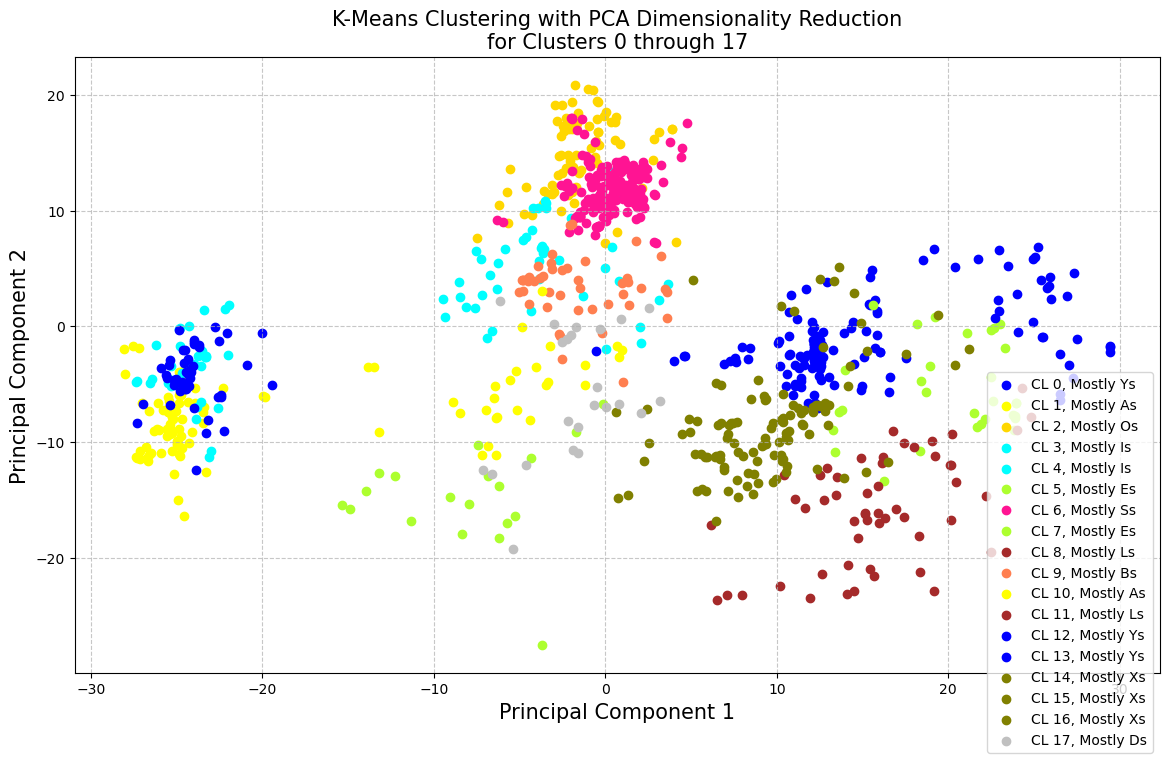

In [720]:
#sets the number of components
n_components = 2
#initializes PCA for reduction
pca = PCA(n_components=n_components)
#applies PCA and transforms the original data into 2D
X_pca = pca.fit_transform(X)

#color list
letter_colormap = ['red', 'gold', 'darkred', 'yellow', 'orange', 'greenyellow', 
                  'peru', 'purple', 'deeppink', 'blue', 'cyan', 'magenta',
                  'brown', 'olive', 'navy', 'teal', 'coral', 'silver']


if len(letter_colormap) < len(asl_keep):
    #if not enough colors, generate a new colormap dynamically 
    letter_colormap = plt.cm.tab20(np.linspace(0, 1, len(asl_keep)))

#gets the unique ASL letters in the dataset  
unique_letters = list(set(y_sample))
#creates a dataframe to map each letter to a color  
color_mapping = pd.DataFrame({
    'color': letter_colormap[:len(unique_letters)],
    'letter_label': unique_letters
})

#list to store colors for representative letters  
pca_colormap = []
for letter in y_rep_letters:
    #finds the color assigned to the current letter
    assigned_color = color_mapping[color_mapping['letter_label'] == letter].iloc[0, 0]
    #adds it to the color list 
    pca_colormap.append(assigned_color)

#figure size for the plot
plt.figure(figsize=(14, 8))

#plots the PCA-transformed data points, colored by cluster
for i in range(n_groups):
    plt.scatter(
        X_pca[kmeans_labs == i, 0],
        X_pca[kmeans_labs == i, 1],
        label=f'CL {i}, Mostly {y_sample[rep_letter_index[i]]}s',
        color=pca_colormap[i]
    )

#adds a legend showing cluster labels and their dominant letter
plt.legend(loc='upper right', bbox_to_anchor=(1, 0.5))
#sets the title for the plot
plt.title(f'K-Means Clustering with PCA Dimensionality Reduction\nfor Clusters 0 through {n_groups-1}',
          fontsize=15)
#labels the x axis 
plt.xlabel('Principal Component 1', fontsize=15)
#labels the y axis
plt.ylabel('Principal Component 2', fontsize=15)
#adds a grid
plt.grid(True, linestyle='--', alpha=0.7)
#displays plot
plt.show()

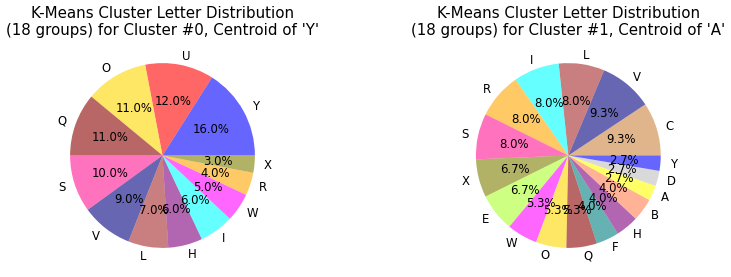

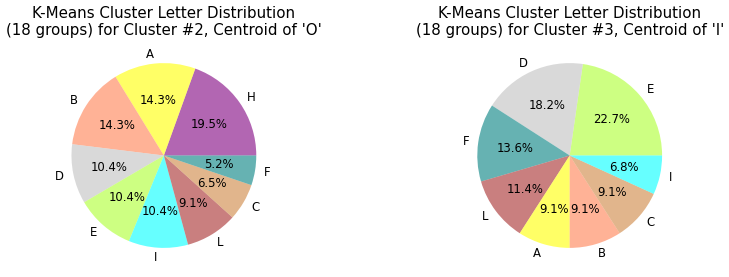

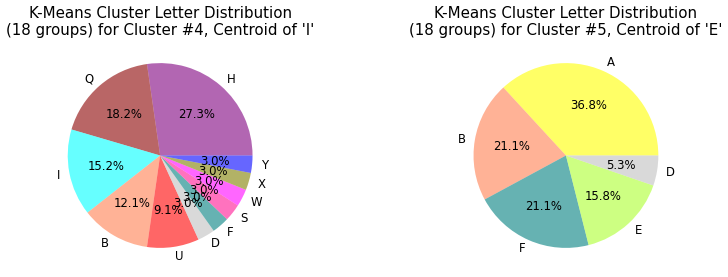

In [721]:
#function for letter distrubution in two clusters
def plot_cluster_results(cluster_num_1, cluster_num_2):
    #creates a df with letter labels  
    sample_data_kmeans_labs = pd.DataFrame({'letter_label': y_sample})
    #adds the assigned k-means cluster label
    sample_data_kmeans_labs['kmeans_lab'] = kmeans_labs

    #gets the count of each letter in cluster 1 
    cluster_1_values = sample_data_kmeans_labs[sample_data_kmeans_labs['kmeans_lab'] == cluster_num_1]['letter_label'].value_counts()

    #sets up a plot for the two clusters  
    fig, axs = plt.subplots(1, 2, figsize=(16, 5), dpi=60)

    #list to store colors for cluster 1 
    pie_1_colors = []
    for letter in cluster_1_values.index:
        #assigns the color for this letter 
        color_row = color_mapping[color_mapping['letter_label'] == letter]
        if not color_row.empty:
            pie_1_colors.append(color_row.iloc[0, 0])
        else:
            #assigns gray if no color is found
            pie_1_colors.append('gray')

    #creates a pie chart for cluster 1 
    axs[0].pie(cluster_1_values.values, labels=cluster_1_values.index, 
               autopct='%1.1f%%', colors=pie_1_colors, 
               wedgeprops={"alpha": 0.6}, textprops={'fontsize': 14})

    #sets the title for cluster 1 pie chart
    axs[0].set_title(f'K-Means Cluster Letter Distribution\n({n_groups} groups) for Cluster #{cluster_num_1}, Centroid of \'{y_sample[rep_letter_index[cluster_num_1]]}\'',
                     fontsize=18)

    #gets the count of each letter in cluster 2 
    cluster_2_values = sample_data_kmeans_labs[sample_data_kmeans_labs['kmeans_lab'] == cluster_num_2]['letter_label'].value_counts()

    #list to store colors for cluster 2
    pie_2_colors = []
    for letter in cluster_2_values.index:
        #assigns the color for this letter
        color_row = color_mapping[color_mapping['letter_label'] == letter]
        if not color_row.empty:
            pie_2_colors.append(color_row.iloc[0, 0])
        else:
            #assigns gray if no color is found
            pie_2_colors.append('gray')

    #creates a pie chart for cluster 2  
    axs[1].pie(cluster_2_values.values, labels=cluster_2_values.index, 
               autopct='%1.1f%%', colors=pie_2_colors, 
               wedgeprops={"alpha": 0.6}, textprops={'fontsize': 14})

    # sets the title for cluster 2
    axs[1].set_title(f'K-Means Cluster Letter Distribution\n({n_groups} groups) for Cluster #{cluster_num_2}, Centroid of \'{y_sample[rep_letter_index[cluster_num_2]]}\'',
                     fontsize=18)

    #adjusts layout to prevent overlap 
    plt.tight_layout
    #displays the plot  
    plt.show()

#calls function for the 2 clusters
plot_cluster_results(0, 1)
plot_cluster_results(2, 3)
plot_cluster_results(4, 5)

High purity cluster 17 (purity: 0.43)


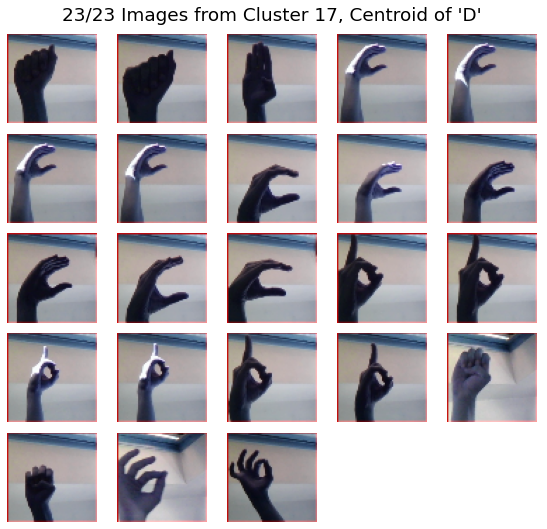

In [722]:
#function for visual from a specific cluster
def plot_cluster_images(cluster_num):
    #gets the indices of all images assigned to this cluster
    cluster_indices = np.where(kmeans_labs == cluster_num)[0]

    #limits the number of images displayed to 81 max  
    num_images = min(81, len(cluster_indices))
    #calculates the number of rows and columns
    rows = int(np.ceil(np.sqrt(num_images)))
    cols = int(np.ceil(num_images / rows))

    #creates the plot and flattens the axes array 
    fig, ax = plt.subplots(rows, cols, figsize=(8, 8), dpi=70)
    ax = ax.flatten()

    #gets the most letter for this cluster
    centroid_letter = y_sample[rep_letter_index[cluster_num]]

    #sets the title with cluster info and the centroid letter 
    fig.suptitle(f"{num_images}/{len(cluster_indices)} Images from Cluster {cluster_num}, Centroid of \'{centroid_letter}\'", 
                 fontsize=19, y=0.94)

    #displays each image and removes axis markings 
    for i in range(num_images):
        ax[i].imshow(X_sample[cluster_indices[i]])
        ax[i].axis('off')

    #hides any extra subplots if there are fewer images than slots 
    for i in range(num_images, len(ax)):
        ax[i].axis('off')

    #adjusts the layout to prevent overlap with the title  
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    #shows the final image grid
    plt.show()

#creates a df linking images to their cluster
sample_data_kmeans_labs = pd.DataFrame({'letter_label': y_sample, 'kmeans_lab': kmeans_labs})

#dict to store purity scores for each cluster
cluster_purity = {}
for cluster in range(n_groups):
    #gets the letter labels of all images in the cluster 
    cluster_letters = sample_data_kmeans_labs[sample_data_kmeans_labs['kmeans_lab'] == cluster]['letter_label']
    if len(cluster_letters) > 0:
        #finds the most common letter in the cluster
        most_common_letter = cluster_letters.value_counts().idxmax()
        #calc purity as the fraction of the dominant letter in the cluster
        purity = cluster_letters.value_counts().max() / len(cluster_letters)
        #stores the cluster's purity score
        cluster_purity[cluster] = purity

#sorts clusters by purity in descending order
sorted_clusters = sorted(cluster_purity.items(), key=lambda x: x[1], reverse=True)

#gets the cluster with the highest purity 
high_purity_cluster = sorted_clusters[0][0]
#gets the cluster with the lowest purity 
low_purity_cluster = sorted_clusters[-1][0]

#prints info about the highest purity cluster 
print(f"High purity cluster {high_purity_cluster} (purity: {sorted_clusters[0][1]:.2f})")
#plots images from the highest purity cluster
plot_cluster_images(high_purity_cluster)

Low purity cluster 1 (purity: 0.09)


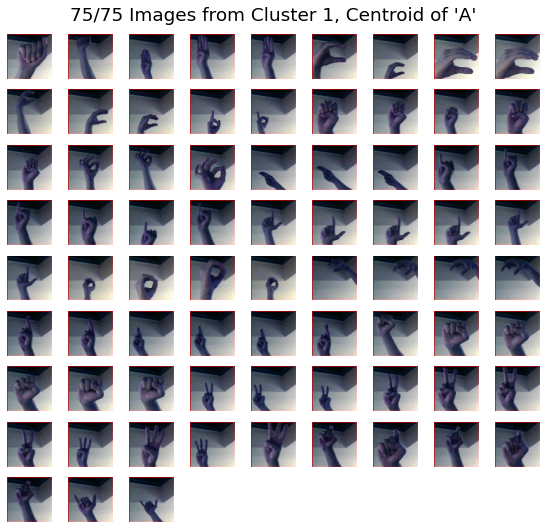

In [723]:
#prints info about the lowest purity cluster 
print(f"Low purity cluster {low_purity_cluster} (purity: {sorted_clusters[-1][1]:.2f})")
#plots images from the lowest purity cluster
plot_cluster_images(low_purity_cluster)

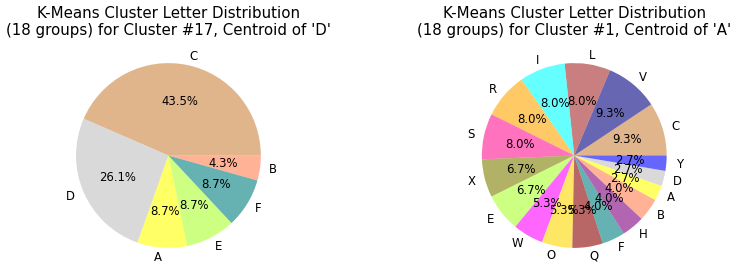

In [724]:
#calls plot_cluster_result function for the 2 clusters
plot_cluster_results(high_purity_cluster, low_purity_cluster)

###K-Means Observations
- A silhouette score of ~0.16 means the clusters are somewhat separated—not great, but not terrible either. That makes sense for something like ASL hand signs, where a lot of letters look pretty similar in shape and positioning.
- Some clusters are much more "pure" than others. However, almost every ASL letter shows up in a cluster to some degree. "A" shares a lot of visual features with other letters, making it hard to separate cleanly using unsupervised clustering.

In [726]:
#function to load, split, and preprocess the dataset
def load_and_preprocess_dataset(train_asl_df, asl_keep, image_size=(64, 64)):
    #empty dataframe to store ASL letters 
    train_df_balanced = pd.DataFrame()
    
    for letter in asl_keep:
        #collects all images for the selected letters
        letter_df = train_asl_df[train_asl_df['letter_label'] == letter]
        train_df_balanced = pd.concat([train_df_balanced, letter_df])

    #resets the index after filtering
    train_df_balanced = train_df_balanced.reset_index(drop=True)

    #Splitting data into training, validation, and test sets
    #first split- 70% for training and 30% into a temp set  
    train_df, temp_df = train_test_split(
        train_df_balanced, 
        test_size=0.3, 
        random_state=42,
        stratify=train_df_balanced['letter_label']
    )

    #second split: divides the temp set equally into validation and test sets
    val_df, test_df = train_test_split(
        temp_df,
        test_size=0.5,
        random_state=42,
        stratify=temp_df['letter_label']
    )

    #resets index for after splitting
    train_df = train_df.reset_index(drop=True)
    val_df = val_df.reset_index(drop=True)
    test_df = test_df.reset_index(drop=True)
    
    #function to load and resize images 
    def load_images(df):
        X = []
        for img_path in df['image_path']:
            img = cv2.imread(img_path)
            img_resized = cv2.resize(img, image_size)
            X.append(img_resized)
        return np.array(X)

    #loads and resizes images for each dataset split
    X_train = load_images(train_df)
    X_val = load_images(val_df)
    X_test = load_images(test_df)

    #grabs the letter labels  
    y_train = train_df['letter_label'].values
    y_val = val_df['letter_label'].values
    y_test = test_df['letter_label'].values

    #label encoder to convert letters into numerical values
    label_encoder = LabelEncoder()

    #encodes the labels into numeric values
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_val_encoded = label_encoder.transform(y_val)
    y_test_encoded = label_encoder.transform(y_test)

    #creates a df mapping letters to their encoded values
    encoded_dict = pd.DataFrame({
        'letter_label': label_encoder.classes_,
        'encoded_label': np.arange(len(label_encoder.classes_))
    })

    #prints out dataset size and class info
    print(f"Training set: {len(X_train)} images")
    print(f"Validation set: {len(X_val)} images")
    print(f"Test set: {len(X_test)} images")


    #returns processed data and label mappings
    return (X_train, y_train, y_train_encoded, 
            X_val, y_val, y_val_encoded, 
            X_test, y_test, y_test_encoded, 
            encoded_dict)

In [727]:
#loads the dataset, splitting it into train, validation, and test sets  
(X_train, y_train, y_train_encoded, 
 X_val, y_val, y_val_encoded,
 X_test, y_test, y_test_encoded,
 encoded_dict) = load_and_preprocess_dataset(train_asl_df, asl_keep)

#normalize pixel values
#scales pixel values to the range [0,1]  
X_train = X_train.astype('float32') / 255.0
X_val = X_val.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

#get shapes for model input
#prints the shape of a single input image 
print(f"Input shape for neural networks: {X_train.shape[1:]}")
#calculates the number of unique classes
num_classes = len(np.unique(y_train_encoded))
#prints the total number of output classes
print(f"Output shape: {num_classes}")

Training set: 6300 images
Validation set: 1350 images
Test set: 1350 images
Input shape for neural networks: (64, 64, 3)
Output shape: 18


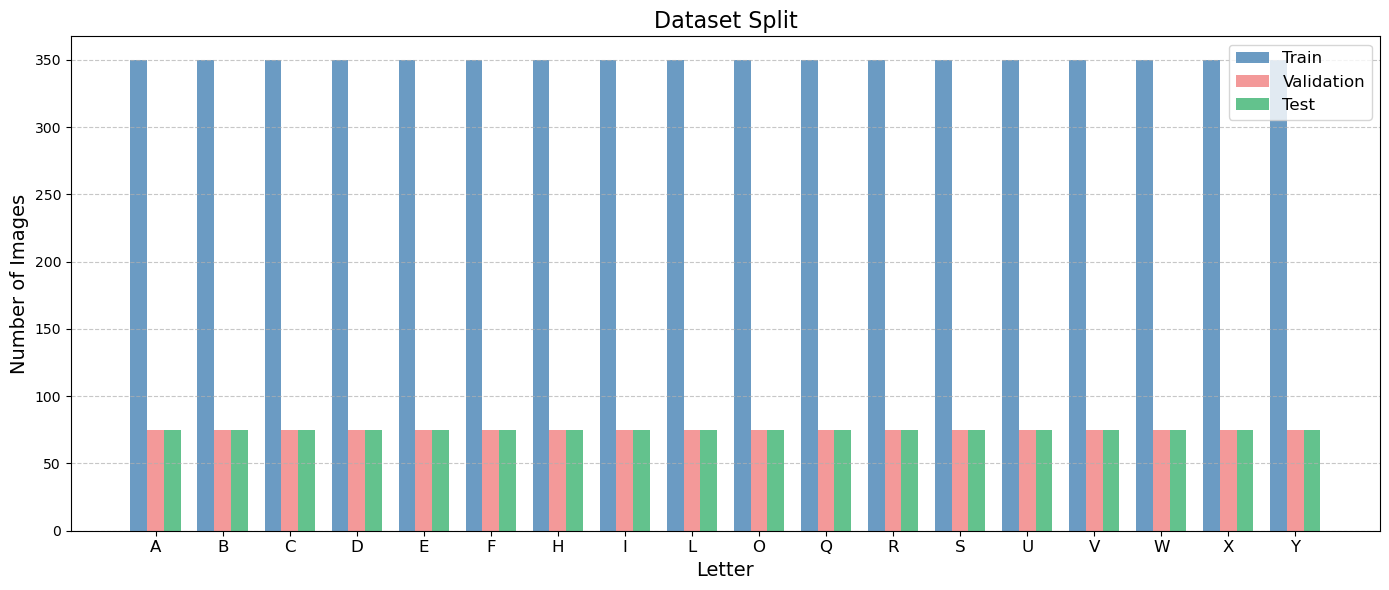

In [728]:
#counts the number of images for each letter in the training set
train_counts = pd.Series(y_train).value_counts().sort_index()
#counts the number of images for each letter in the validation set
val_counts = pd.Series(y_val).value_counts().sort_index()
#counts the number of images for each letter in the test set
test_counts = pd.Series(y_test).value_counts().sort_index()

#sets up the figure size 
plt.figure(figsize=(14, 6))
#width of each bar
bar_width = 0.25
#creates an array of indices for ASL letters  
x = np.arange(len(asl_keep))

#plots the training set distribution in blue
plt.bar(x - bar_width, train_counts, bar_width, label='Train', color='steelblue', alpha=0.8)
#plots the validation set distribution in red
plt.bar(x, val_counts, bar_width, label='Validation', color='lightcoral', alpha=0.8)
#plots the test set distribution in green
plt.bar(x + bar_width, test_counts, bar_width, label='Test', color='mediumseagreen', alpha=0.8)

#labels the x-axis
plt.xlabel('Letter', fontsize=14)
#labels the y-axis
plt.ylabel('Number of Images', fontsize=14)
#sets the title of the plot 
plt.title('Dataset Split', fontsize=16)
# x-axis labels match ASL letters
plt.xticks(x, asl_keep, fontsize=12)
#adds a legend
plt.legend(fontsize=12)
#gridline
plt.grid(axis='y', linestyle='--', alpha=0.7)
#prevent overlap
plt.tight_layout()
#displays
plt.show()

In [729]:
#func to plot accuracy and loss training
def plot_training_history(history, model_name):
    #sets up the figure size for better visibility
    plt.figure(figsize=(12, 5))

    #accuracy plot
    #creates the first subplot
    plt.subplot(1, 2, 1)
    #plots training accuracy over epochs 
    plt.plot(history.history['accuracy'], label='Training', linewidth=2)
    #plots validation accuracy over epochs
    plt.plot(history.history['val_accuracy'], label='Validation', linewidth=2)
    #sets the title for the accuracy plot
    plt.title(f'{model_name} - Accuracy', fontsize=15)
    #labels the axes
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    #adds a legend 
    plt.legend(fontsize=12)
    #dashed grid
    plt.grid(True, linestyle='--', alpha=0.7)

    #loss plot
    #creates the second subplot
    plt.subplot(1, 2, 2)
    #plots training loss over epochs
    plt.plot(history.history['loss'], label='Training', linewidth=2, color='orange')
    #plots validation loss over epochs
    plt.plot(history.history['val_loss'], label='Validation', linewidth=2, color='red')
    #sets the title for the loss plot
    plt.title(f'{model_name} - Loss', fontsize=15)
    #labels the axes
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    #adds a legend
    plt.legend(fontsize=12)
    #dashed grid
    plt.grid(True, linestyle='--', alpha=0.7)

    #displays the accuracy and loss plots
    #prevent overlap
    plt.tight_layout()
    #displays
    plt.show()

#function to calculate and plot accuracy per ASL letter class
def analyze_per_class_accuracy(y_true, y_pred, encoded_dict, model_name):
    #list to store accuracy values for each class
    class_accuracies = []
    #list to store class labels
    class_labels = []

    #gets all test samples for this letter
    for i, label in enumerate(encoded_dict['letter_label']):
        #gets all test samples for this letter
        class_indices = np.where(y_test == label)[0]

        #skips if there are no test samples for this class
        if len(class_indices) == 0:
            continue
        
        #get predictions for this class
        class_true = y_test_encoded[class_indices]
        class_pred = y_pred[class_indices]
        
        #calculate accuracy
        #finds the percentage of correct predictions for this letter
        accuracy = np.mean(class_pred == class_true)
        #stores accuracy and label for plotting
        class_accuracies.append(accuracy)
        class_labels.append(label)
    
    #print class accuracies
    print(f"\n{model_name} Test Accuracy by Class:")
    print("-------------------------------------")
    total_acc = 0

    #prints accuracy for each class
    for i, label in enumerate(class_labels):
        acc = class_accuracies[i]
        total_acc += acc
        print(f"Class '{label}' Accuracy: {acc:.2%}")

    #prints the average accuracy across all classes
    print("-------------------------------------")
    print(f"Average Class Accuracy: {total_acc / len(class_labels):.2%}")
    
    #plot class 
    plt.figure(figsize=(14, 6))
    #creates a bar chart showing accuracy for each letter
    bars = plt.bar(class_labels, class_accuracies, color='lightblue', alpha=0.8)
    
    #add text labels on top of bars
    for bar in bars:
        height = bar.get_height()
        #adds percentage labels above each bar
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.1%}', ha='center', va='bottom', fontsize=10)

    #sets title for the plot
    plt.title(f'{model_name} Accuracy by Class', fontsize=16)
    #labels x and y axes 
    plt.xlabel('ASL Letter', fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)
    plt.ylim(0, 1.1)
    #horizontal grid
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    #prevent overlap
    plt.tight_layout()
    #displays
    plt.show()
    
    return class_accuracies, class_labels

#function to visualize predictions
def visualize_predictions(X_test_data, y_test_data, y_pred, y_pred_proba, encoded_dict, model_name, num_examples=4):
    #get correctly and incorrectly classified examples
    correct_indices = np.where(y_test_encoded == y_pred)[0]
    incorrect_indices = np.where(y_test_encoded != y_pred)[0]
    
    #get samples to display
    correct_samples = np.random.choice(correct_indices, min(num_examples//2, len(correct_indices)), replace=False)
    incorrect_samples = np.random.choice(incorrect_indices, min(num_examples//2, len(incorrect_indices)), replace=False)

    #combines correct and incorrect samples for visualization
    samples = np.concatenate([correct_samples, incorrect_samples])
    
    #create figure
    plt.figure(figsize=(16, 4 * (num_examples // 2)))
    
    for i, idx in enumerate(samples):
        #get true and predicted labels
        true_label_idx = y_test_encoded[idx]
        pred_label_idx = y_pred[idx]
        
        true_label = encoded_dict.loc[encoded_dict['encoded_label'] == true_label_idx, 'letter_label'].iloc[0]
        pred_label = encoded_dict.loc[encoded_dict['encoded_label'] == pred_label_idx, 'letter_label'].iloc[0]
        
        #plot image
        plt.subplot(num_examples // 2, 4, i + 1)
        plt.imshow(X_test_data[idx])
        
        #set title color based on correctness
        title_color = 'green' if true_label_idx == pred_label_idx else 'red'
        plt.title(f"True: {true_label} | Pred: {pred_label}", color=title_color, fontsize=12)
        plt.axis('off')
        
        #plot probabilities for top 5 classes
        plt.subplot(num_examples // 2, 4, i + 1 + num_examples)
        
        #get top 5 predictions
        probs = y_pred_proba[idx]
        top_indices = np.argsort(probs)[-5:][::-1]
        top_probs = probs[top_indices]
        top_labels = [encoded_dict.loc[encoded_dict['encoded_label'] == idx, 'letter_label'].iloc[0] 
                      for idx in top_indices]
        
        # create bar colors (green for correct, red for predicted if incorrect)
        bar_colors = ['lightgray'] * 5
        for j, idx in enumerate(top_indices):
            if idx == true_label_idx:
                bar_colors[j] = 'green'
            elif idx == pred_label_idx and pred_label_idx != true_label_idx:
                bar_colors[j] = 'red'
        
        #plot bars
        bars = plt.bar(range(5), top_probs, color=bar_colors)
        plt.xticks(range(5), top_labels, rotation=45)
        plt.ylim(0, 1)
        plt.ylabel('Probability')
        plt.title('Top 5 Predictions', fontsize=10)

    #sets the main title  
    plt.suptitle(f"{model_name} Predictions", fontsize=16, y=1.05)
    # prevent overlap
    plt.tight_layout()
    #displays plot
    plt.show()

In [730]:
#flatten images function
def flatten_images(image_array):
    return image_array.reshape(image_array.shape[0], -1)

#flattens each image from 64x64x3 into a 1D array of 12288
X_train_flattened = flatten_images(X_train)
#flattens validation images the same way
X_val_flattened = flatten_images(X_val)
#flattens test images the same way
X_test_flattened = flatten_images(X_test)

# Print information about the flattened shape
print(f"Flattened shape: {X_train_flattened.shape[1:]} features")
print(f"Each image converted from {X_train.shape[1:]} to {X_train_flattened.shape[1]} values")

Flattened shape: (12288,) features
Each image converted from (64, 64, 3) to 12288 values


###MLP Supervised Learning
- Now that we've seen how ASL letters naturally cluster based on visual similarity, let's build our first supervised learning model to classify them. We'll start with a Multi-Layer Perceptron.
- The MLP works by flattening each image into a single long vector of pixel values. This means our 64×64×3 RGB images will be transformed into vectors with 12,288 features. The neural network then learns to map these flattened representations to the correct letter labels

In [732]:
asl_mlp = tf.keras.Sequential([
    #input layer
    #12,288 features from the flattened 64x64x3 images
    layers.Input(shape=(X_train_flattened.shape[1],)),
    
    #hidden layers
    #first dense layer with 256 neurons and ReLU activation  
    layers.Dense(256, activation='relu', name='hidden1'),
    #dropout layer to prevent overfitting
    layers.Dropout(0.3),
    #second dense layer with 128 neurons
    layers.Dense(128, activation='relu', name='hidden2'),
    #another dropout layer for regularization
    layers.Dropout(0.3),
    #third dense layer with 64 neurons
    layers.Dense(64, activation='relu', name='hidden3'),
    
    #output layer with 'num_classes' neurons and softmax activation
    layers.Dense(num_classes, activation='softmax', name='output')
    #defines the model and names it
], name='asl_mlp')

#compile the model
optimizer = Adam(learning_rate=0.0001)  #lower learning rate for stability
#uses sparse categorical crossentropy since labels are integers
#tracks accuracy as the evaluation metric
asl_mlp.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

#display model summary
asl_mlp.summary()

Model: "asl_mlp"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden1 (Dense)                 │ (None, 256)            │     3,145,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 18)             │         1,170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,188,306 (12.16 MB)

 Trainable params: 3,188,306 (12.16 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#sets up early stopping to monitor validation loss
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10, #stops training if val_loss doesnt improve for 10 epochs
    restore_best_weights=True, #restores the best model weights to prevent overfit
    verbose=1
)

#train the model
mlp_history = asl_mlp.fit(
    X_train_flattened, y_train_encoded,
    epochs=50,  #trains the model for up to 50 epochs
    batch_size=32, #batch size of 32 for training
    validation_data=(X_val_flattened, y_val_encoded), #validates on the validation set after each epoch
    callbacks=[early_stopping], #uses early stopping to prevent overtraining
    verbose=1
)

Epoch 1/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.0565 - loss: 2.9693 - val_accuracy: 0.0822 - val_loss: 2.8661
Epoch 2/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.0736 - loss: 2.8741 - val_accuracy: 0.1104 - val_loss: 2.8110
Epoch 3/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.1024 - loss: 2.8158 - val_accuracy: 0.1237 - val_loss: 2.7111
Epoch 4/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.1043 - loss: 2.7372 - val_accuracy: 0.1393 - val_loss: 2.6274
Epoch 5/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.1159 - loss: 2.6624 - val_accuracy: 0.1756 - val_loss: 2.5372
Epoch 6/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.1371 - loss: 2.5714 - val_accuracy: 0.1874 - val_loss: 2.4487
Epoch 7/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.1435 - loss: 2.5447 - val_accuracy: 0.1800 - val_loss: 2.4115
Epoch 8/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.1550 - loss: 2.4868 - val_accuracy: 0.

In [ ]:
#evaluates the trained model on the test set
print("\nMLP model on test set:")
mlp_test_loss, mlp_test_acc = asl_mlp.evaluate(X_test_flattened, y_test_encoded, verbose=0)
#prints the test accuracy
print(f"MLP Test Accuracy: {mlp_test_acc:.4f}")

#calls plot_training_history func to visualize accuracy
plot_training_history(mlp_history, 'MLP Neural Network')

In [ ]:
#generates class probability predictions for the test set 
mlp_predictions = asl_mlp.predict(X_test_flattened)
#gets the index of the highest probability for each prediction
mlp_predicted_classes = np.argmax(mlp_predictions, axis=1)

#evaluates accuracy for each ASL letter using the analyze_per_class_accuracy func
mlp_class_accuracies, mlp_class_labels = analyze_per_class_accuracy(
    y_test, mlp_predicted_classes, encoded_dict, 'MLP Neural Network'
)

In [ ]:
#visualize some predictions from the MLP model
visualize_predictions(X_test, y_test, mlp_predicted_classes, mlp_predictions, 
                      encoded_dict, 'MLP Neural Network')

###MLP Observation
- MLP accuracy is low ~ 10-30% on average, bad for image classification.
- Big accuracy gaps – some letters are easy, others impossible.
- High accuracy is likely due to distinct shapes.
- Total failure: Some letters the model couldn't recognize them at all.
- Main issue: MLP flattens images, losing spatial info crucial for ASL recognition.

###CNN Supervised Learning
- After seeing the MLP's struggle with our images, let's try an approach that's specifically designed for image data: a Convolutional Neural Network 

In [ ]:
asl_cnn = tf.keras.Sequential([
    layers.Input(shape=X_train.shape[1:]),
    #first convolutional layer with 32 filters and a 3x3 kernel
    #same padding ensures output size remains the same
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    #normalizes activations to stabilize training 
    layers.BatchNormalization(),
    #another convolutional layer with 32 filters
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    #max pooling reduces spatial dimensions
    layers.MaxPooling2D((2, 2)),
    #dropout to reduce overfitting
    layers.Dropout(0.25),
    
    #second convolutional block
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    
    #third convolutional block
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    
    #flattens the feature maps into a 1D vector
    layers.Flatten(),
    #connected layer with 256
    layers.Dense(256, activation='relu'),
    #normalizes activations for stability
    layers.BatchNormalization(),
    #higher dropout
    layers.Dropout(0.5),
    #output layer with softmax activation
    layers.Dense(num_classes, activation='softmax')
], name='asl_cnn') #defines the CNN model and names it

#compile model
optimizer = RMSprop(learning_rate=0.0001) #small learning rate for stability
asl_cnn.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

#display model summary
asl_cnn.summary()